C:\Users\HP\AppData\Local\Temp\ipykernel_24172\2789998405.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  week = int(row[0].split()[1]) if isinstance(row[0], str) else int(row[0])
C:\Users\HP\AppData\Local\Temp\ipykernel_24172\2789998405.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.notna(row[k]):
C:\Users\HP\AppData\Local\Temp\ipykernel_24172\2789998405.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  groundin

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 3550H with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1025 rows, 1508 columns and 33151 nonzeros
Model fingerprint: 0x338660cc
Variable types: 0 continuous, 1508 integer (1040 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+04, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 917 rows and 1155 columns
Presolve time: 0.02s
Presolved: 108 rows, 353 columns, 1857 nonzeros
Variable types: 0 continuous, 353 integer (212 binary)
Found heuristic solution: objective 1.095902e+07

Root relaxation: objective 5.237735e+06, 112 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

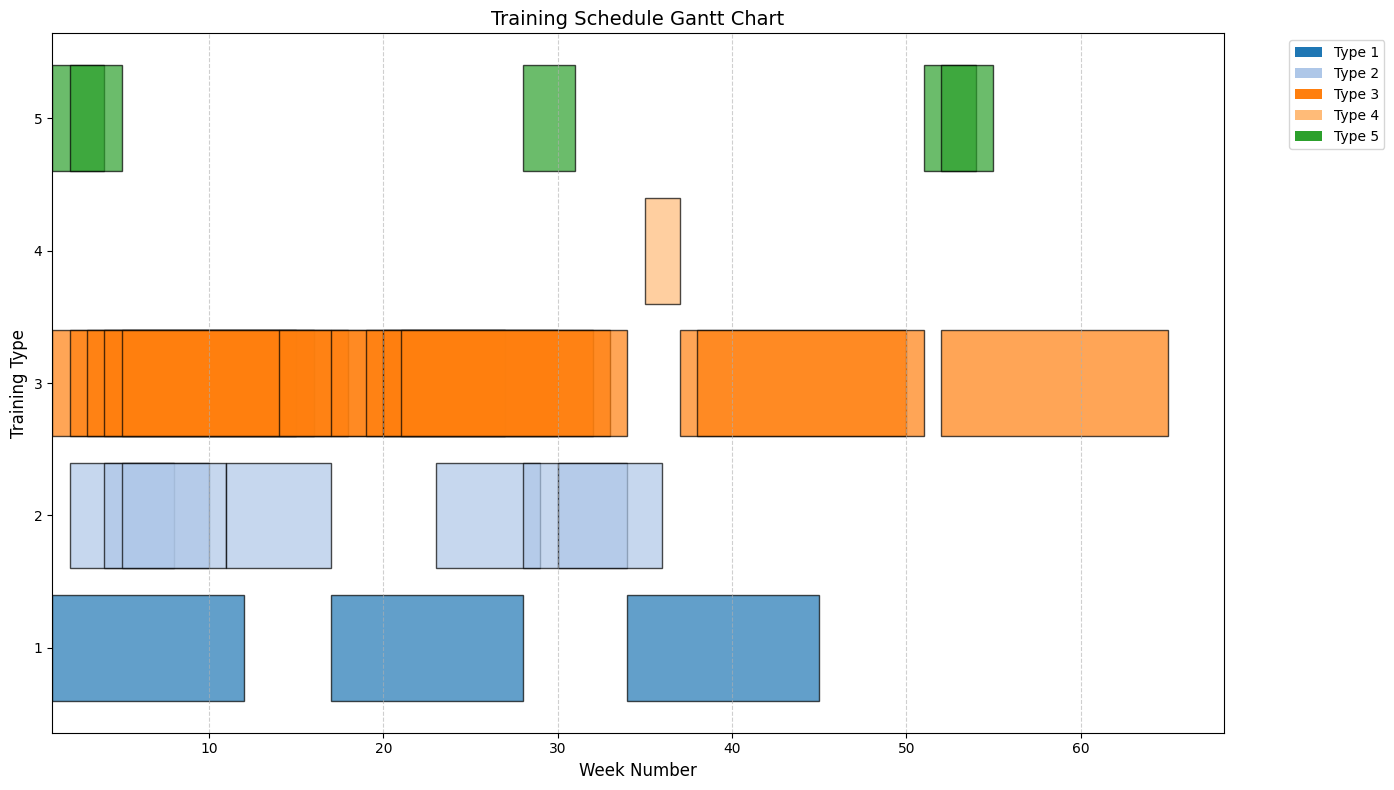

In [3]:
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from tabulate import tabulate
import gurobipy as gp

# Data Loading from CSV Files

# Load all CSV files
initial_crew = pd.read_csv('CrewTrainingData - Initial Crew.csv')
crew_qual = pd.read_csv('CrewTrainingData - Initial Crew Type Qualification.csv')
crew_demand = pd.read_csv('CrewTrainingData - Crew Demand.csv')
grounding_cost = pd.read_csv('CrewTrainingData - Grounded Aircraft Cost.csv')
crew_leaving = pd.read_csv('CrewTrainingData - Crew Leaving.csv')
eoy_req = pd.read_csv('CrewTrainingData - Airbus Crew EOY Requirement.csv')
sim_avail = pd.read_csv('CrewTrainingData - Simulator Availability.csv')
training_types = pd.read_csv('CrewTrainingData - Training Types.csv')
training_details = pd.read_csv('CrewTrainingData - Training.csv')

# Data Preparation


# Clean and process data
initial_crew_dict = dict(zip(initial_crew['Rating'], initial_crew['Total']))
crew_qual_dict = {(row['Rating'], row['Type']): row['Number Qualified'] 
                  for _, row in crew_qual.iterrows() if pd.notna(row['Number Qualified'])}

# Process demand data - now properly interpreted as requiring both FO and C
demand_dict = {}
for _, row in crew_demand.iterrows():
    if pd.notna(row['Demand']):
        week_num = int(row['Week'].split()[1])
        demand_dict[(row['Aircraft'], week_num)] = row['Demand']

# Process grounding costs - properly structured
grounding_cost_dict = {}
for _, row in grounding_cost.iterrows():
    week = int(row[0].split()[1]) if isinstance(row[0], str) else int(row[0])
    for k in range(1, 11):
        if pd.notna(row[k]):
            grounding_cost_dict[(week, k)] = float(str(row[k]).replace(',', ''))

# Process simulator availability
sim_avail_dict = {int(row[0].split()[1]): row[1] 
                  for _, row in sim_avail.iterrows() if pd.notna(row[1])}

# Process training details
training_duration = {}
instructors_needed = {}
simulators_needed = {}
capacity_gained = {}

for _, row in training_details.iterrows():
    t = row['Training Type']
    week = row['Week of Training']
    
    if pd.notna(row['Capacity Needed']):
        instructors_needed[(t, week)] = row['Capacity Needed']
    if pd.notna(row['Simulator Needed']):
        simulators_needed[(t, week)] = row['Simulator Needed']
    if pd.notna(row['Capacity Gained']):
        capacity_gained[(t, week)] = row['Capacity Gained']
    
    if t not in training_duration or week > training_duration[t]:
        training_duration[t] = week

# Process end-of-year requirements
eoy_req_dict = dict(zip(eoy_req['Rating'], eoy_req['Required EOY']))

# Process crew leaving data
crew_leaving_dict = {}
for week in range(1, 53):
    week_str = f"Week {week}"
    if week_str in crew_leaving.columns:
        for col in crew_leaving.columns[1:]:
            if pd.notna(crew_leaving.at[week-1, col]):
                parts = col.split()
                rating = f"{parts[0]} {parts[1]}"
                qual = parts[3] if len(parts) > 3 else None
                crew_leaving_dict[(rating, qual, week)] = crew_leaving.at[week-1, col]

# =============================================
# Model Creation
# =============================================
model = gp.Model("CrewTrainingOptimization")

# =============================================
# Sets (Indices)
# =============================================
TrainingTypes = list(training_duration.keys())
Weeks = list(range(1, 53))
AircraftTypes = list(set([a for a, _ in demand_dict.keys()]))
CrewRatings = list(initial_crew_dict.keys())
GroundedCounts = list(range(1, 11))

# =============================================
# Decision Variables
# =============================================
x = model.addVars(TrainingTypes, Weeks, vtype=GRB.INTEGER, name="x")  # Crews starting training
g = model.addVars(AircraftTypes, Weeks, vtype=GRB.INTEGER, name="g")  # Grounded aircraft
z = model.addVars(AircraftTypes, Weeks, GroundedCounts, vtype=GRB.BINARY, name="z")  # Grounding cost linearization
h = model.addVars([4,5], Weeks, vtype=GRB.INTEGER, name="h")  # External hiring

# =============================================
# Objective Function
# =============================================
# Minimize total cost (grounding + hiring) with realistic hiring costs
grounding_cost = gp.quicksum(
    grounding_cost_dict.get((w,k), 0) * z[a,w,k]
    for a in AircraftTypes for w in Weeks for k in GroundedCounts
)

# Adjusted hiring costs - more realistic values
hiring_cost = gp.quicksum(
    15000 * h[4,w] for w in Weeks  # Boeing FO hiring cost
) + gp.quicksum(
    20000 * h[5,w] for w in Weeks  # Airbus FO hiring cost (higher due to more training)
)

model.setObjective(grounding_cost + hiring_cost, GRB.MINIMIZE)

# =============================================
# Constraints
# =============================================
def input_ratings(r):
    """Returns training types that consume crew of rating r"""
    if r == "Boeing FO": return [1, 2]
    elif r == "Boeing C": return [3]
    elif r == "Airbus FO": return []
    elif r == "Airbus C": return []
    return []

def output_ratings(r):
    """Returns training types that produce crew of rating r"""
    if r == "Boeing FO": return [4]
    elif r == "Boeing C": return [2]
    elif r == "Airbus FO": return [1, 5]
    elif r == "Airbus C": return [3]
    return []

# 1. Crew availability constraints
for r in CrewRatings:
    for w in Weeks:
        # Crew consumed (in training)
        consumed = gp.quicksum(
            x[t,w_prime]
            for t in input_ratings(r)
            for w_prime in range(1, w+1)
        )

        # Crew produced (from completed training)
        produced = gp.quicksum(
            x[t,w_prime]
            for t in output_ratings(r)
            for w_prime in range(1, w - training_duration[t] + 1)
        )

        # Crew leaving
        left = sum(
            v for (rating, _, week), v in crew_leaving_dict.items()
            if rating == r and week <= w
        )

        model.addConstr(
            initial_crew_dict[r] - left - consumed + produced >= 0,
            name=f"crew_avail_{r}_{w}"
        )

# 2. Aircraft grounding constraints - properly accounting for both FO and C requirements
for a in AircraftTypes:
    for w in Weeks:
        fo_rating = f"{a} FO"
        c_rating = f"{a} C"

        # Available FO and C
        available_fo = initial_crew_dict[fo_rating] - gp.quicksum(
            x[t,w_prime] for t in input_ratings(fo_rating) for w_prime in range(1,w+1)
        ) + gp.quicksum(
            x[t,w_prime] for t in output_ratings(fo_rating)
            for w_prime in range(1, w - training_duration[t] + 1)
        )

        available_c = initial_crew_dict[c_rating] - gp.quicksum(
            x[t,w_prime] for t in input_ratings(c_rating) for w_prime in range(1,w+1)
        ) + gp.quicksum(
            x[t,w_prime] for t in output_ratings(c_rating)
            for w_prime in range(1, w - training_duration[t] + 1)
        )

        # Subtract crew leaving
        fo_left = sum(
            v for (rating, _, week), v in crew_leaving_dict.items()
            if rating == fo_rating and week <= w
        )
        c_left = sum(
            v for (rating, _, week), v in crew_leaving_dict.items()
            if rating == c_rating and week <= w
        )

        available_fo -= fo_left
        available_c -= c_left

        # Add external hiring
        if a == "Boeing":
            available_fo += gp.quicksum(
                h[4,w_prime] for w_prime in range(1, w - 2 + 1)  # Hiring takes 2 weeks
            )
        elif a == "Airbus":
            available_fo += gp.quicksum(
                h[5,w_prime] for w_prime in range(1, w - 3 + 1)  # Hiring takes 3 weeks
            )

        # Grounding is max(0, demand - min(available_fo, available_c))
        model.addConstr(
            g[a,w] >= demand_dict.get((a,w), 0) - available_fo,
            name=f"grounding_fo_{a}_{w}"
        )
        model.addConstr(
            g[a,w] >= demand_dict.get((a,w), 0) - available_c,
            name=f"grounding_c_{a}_{w}"
        )
        model.addConstr(
            g[a,w] >= 0,
            name=f"grounding_nonneg_{a}_{w}"
        )

# 3. Grounding cost linearization - properly implemented
for a in AircraftTypes:
    for w in Weeks:
        model.addConstr(
            g[a,w] == gp.quicksum(k * z[a,w,k] for k in GroundedCounts),
            name=f"grounding_linear_{a}_{w}"
        )
        model.addConstr(
            gp.quicksum(z[a,w,k] for k in GroundedCounts) == 1,
            name=f"grounding_select_{a}_{w}"
        )

# 4. External hiring triggers - with realistic constraints
for t in [4,5]:
    for w in Weeks:
        a = "Boeing" if t == 4 else "Airbus"
        rating = f"{a} FO"

        available = initial_crew_dict[rating] - gp.quicksum(
            x[t_prime,w_prime] for t_prime in input_ratings(rating)
            for w_prime in range(1,w+1)
        ) + gp.quicksum(
            x[t_prime,w_prime] for t_prime in output_ratings(rating)
            for w_prime in range(1, w - training_duration[t_prime] + 1)
        )

        # Subtract crew leaving
        left = sum(
            v for (r, _, week), v in crew_leaving_dict.items()
            if r == rating and week <= w
        )
        available -= left

        # Add previously hired crew
        if t == 4:
            available += gp.quicksum(
                h[4,w_prime] for w_prime in range(1, w - 2 + 1)
            )
        else:
            available += gp.quicksum(
                h[5,w_prime] for w_prime in range(1, w - 3 + 1)
            )

        model.addConstr(
            h[t,w] >= demand_dict.get((a,w), 0) - available,
            name=f"hiring_trigger_{t}_{w}"
        )

# 5. Simulator availability
for w in Weeks:
    model.addConstr(
        gp.quicksum(
            simulators_needed.get((t,tau), 0) * x[t,w-tau+1]
            for t in TrainingTypes
            for tau in range(1, training_duration[t]+1)
            if w-tau+1 >= 1
        ) <= sim_avail_dict.get(w, 0),
        name=f"simulators_{w}"
    )

# 6. End-of-year requirements
for r in ["Airbus FO", "Airbus C"]:
    model.addConstr(
        initial_crew_dict[r]
        - sum(v for (rating, _, _), v in crew_leaving_dict.items() if rating == r)
        - gp.quicksum(x[t,w] for t in input_ratings(r) for w in Weeks)
        + gp.quicksum(x[t,w] for t in output_ratings(r) for w in Weeks)
        + (gp.quicksum(h[5,w] for w in Weeks) if r == "Airbus FO" else 0)
        >= eoy_req_dict[r],
        name=f"eoy_{r}"
    )

# 7. Training capacity constraints
for t in TrainingTypes:
    for w in Weeks:
        if (t,w) in instructors_needed:
            model.addConstr(
                x[t,w] <= 4,  # Max students per training (from data)
                name=f"training_capacity_{t}_{w}"
            )

# =============================================
# Enhanced Output Functions
# =============================================
def print_formatted_summary(model, total_hired, total_grounded):
    """Print formatted summary table with key metrics"""
    # Calculate EOY crew numbers
    airbus_fo_final = initial_crew_dict["Airbus FO"] \
        - sum(v for (r,_,_),v in crew_leaving_dict.items() if r == "Airbus FO") \
        + sum(x[t,w].x for t in output_ratings("Airbus FO") for w in Weeks) \
        + sum(h[5,w].x for w in Weeks)
    
    airbus_c_final = initial_crew_dict["Airbus C"] \
        - sum(v for (r,_,_),v in crew_leaving_dict.items() if r == "Airbus C") \
        + sum(x[t,w].x for t in output_ratings("Airbus C") for w in Weeks)
    
    max_grounded = max(g[a,w].x for a in AircraftTypes for w in Weeks)
    
    summary_data = [
        ["Total Cost", f"${model.objVal:,.2f}"],
        ["Grounding Cost", f"${sum(grounding_cost_dict.get((w,int(g[a,w].x)),0) for a in AircraftTypes for w in Weeks):,.2f}"],
        ["Hiring Cost", f"${15000*sum(h[4,w].x for w in Weeks) + 20000*sum(h[5,w].x for w in Weeks):,.2f}"],
        ["External Hires", total_hired],
        ["Aircraft Grounded", total_grounded],
        ["Airbus FO EOY", f"{airbus_fo_final}/{eoy_req_dict['Airbus FO']}"],
        ["Airbus C EOY", f"{airbus_c_final}/{eoy_req_dict['Airbus C']}"],
        ["Max Weekly Groundings", max_grounded],
        ["Training Programs Started", sum(x[t,w].x for t in TrainingTypes for w in Weeks)]
    ]
    
    print("\n" + "="*40)
    print("Optimization Results Summary")
    print("="*40)
    print(tabulate(summary_data, headers=["Metric", "Value"], tablefmt="pretty"))
    print("="*40)

def plot_gantt_chart():
    """Generate Gantt chart of training schedule"""
    plt.figure(figsize=(14,8))
    colors = plt.cm.tab20.colors
    training_colors = {t: colors[i%20] for i,t in enumerate(TrainingTypes)}
    
    for t in TrainingTypes:
        for w in Weeks:
            if x[t,w].x > 0.5:
                duration = training_duration[t]
                plt.barh(y=t, width=duration, left=w, 
                        color=training_colors[t], edgecolor='black', alpha=0.7)
    
    plt.title("Training Schedule Gantt Chart", fontsize=14)
    plt.xlabel("Week Number", fontsize=12)
    plt.ylabel("Training Type", fontsize=12)
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    
    legend_elements = [Patch(facecolor=training_colors[t], label=f'Type {t}')
                      for t in TrainingTypes]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig("training_schedule_gantt.png", dpi=300)
    print("\nSaved Gantt chart to training_schedule_gantt.png")



# =============================================
# Solve and Enhanced Output
# =============================================
model.setParam('OutputFlag', 1)
model.optimize()

if model.status == GRB.OPTIMAL:
    # Calculate summary statistics
    total_hired = sum(h[t,w].x for t in [4,5] for w in Weeks)
    total_grounded = sum(g[a,w].x for a in AircraftTypes for w in Weeks)
    
    # Print header
    print("\n" + "="*40)
    print(f"Optimal Solution Found - Total Cost: ${model.objVal:,.2f}")
    print("="*40 + "\n")
    
    # 1. Print formatted summary
    print_formatted_summary(model, total_hired, total_grounded)
    
    # 2. Generate visualizations
    plot_gantt_chart()
   
    
    # 3. Save CSV files
    results = []
    for t in TrainingTypes:
        for w in Weeks:
            if x[t,w].x > 0.5:
                results.append({
                    'TrainingType': t,
                    'StartWeek': w,
                    'Crews': x[t,w].x,
                    'Type': 'RegularTraining'
                })
    
    for t in [4,5]:
        for w in Weeks:
            if h[t,w].x > 0.5:
                results.append({
                    'TrainingType': t,
                    'StartWeek': w,
                    'Crews': h[t,w].x,
                    'Type': 'ExternalHire'
                })
    
    pd.DataFrame(results).to_csv('crew_training_schedule.csv', index=False)
    print("\nSaved training schedule to crew_training_schedule.csv")
    
    grounding_results = []
    for a in AircraftTypes:
        for w in Weeks:
            if g[a,w].x > 0.5:
                grounding_results.append({
                    'Aircraft': a,
                    'Week': w,
                    'Grounded': g[a,w].x,
                    'GroundingCost': grounding_cost_dict.get((w, int(g[a,w].x)), 0)
                })
    
    pd.DataFrame(grounding_results).to_csv('grounded_aircraft.csv', index=False)
    print("Saved grounding details to grounded_aircraft.csv")
    
    # 4. Print critical insights
    print("\nCritical Insights:")
    max_ground = 0
    for a in AircraftTypes:
        for w in Weeks:
            if g[a,w].x > max_ground:
                max_ground = g[a,w].x
                max_week = (a, w)
    print(f"- Peak Grounding: Week {max_week[1]} ({max_week[0]}) - {max_ground} aircraft")
    
    print("\n- Hiring Summary:")
    if total_hired > 0:
        hires = [(t,w,h[t,w].x) for t in [4,5] for w in Weeks if h[t,w].x > 0]
        hires.sort(key=lambda x: x[1])
        for t,w,qty in hires:
            print(f"  Week {w}: {qty} crews hired via Training {t} (cost: ${15000*qty if t==4 else 20000*qty:,.0f})")
    else:
        print("  No external hiring required in optimal solution")
    
    # 5. Resource utilization analysis
    print("\nResource Utilization Warnings:")
    for w in Weeks:
        used = 0
        # Calculate total simulator usage for the week
        for t in TrainingTypes:
            for tau in range(1, training_duration[t] + 1):
                if w - tau + 1 >= 1:  # Check if training overlaps with this week
                    used += simulators_needed.get((t, tau), 0) * x[t, w - tau + 1].x
                    
        available = sim_avail_dict.get(w, 0)
        
        # Print warning if utilization exceeds 90%
        if available > 0 and (used / available) > 0.9:
            print(f"  Week {w}: Simulator utilization at {(used/available)*100:.1f}%")

else:
    print("\nNo optimal solution found")
    print(f"Model status: {model.status}")

print("\nOptimization complete. Check generated files and visualizations.")